# Comparing Task-Optimized RNN to Neural Data

<a href="https://colab.research.google.com/github/nacloos/diffscore/blob/master/examples/rnn-data-similarity-mante2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


This notebook illustrates how to use the package to train an RNN on a contextual decision making task and comparing it to the [Mante2013](https://www.nature.com/articles/nature12742) dataset using similarity measures.

It uses [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) and will use the GPU if available.

In [1]:
%load_ext autoreload
%autoreload 2

Install requirements (if not already installed):

In [1]:
!git clone https://github.com/nacloos/diffscore.git
!cd diffscore
!pip install -e .

Cloning into 'diffscore'...


Obtaining file:///C:/Users/Nathan%20Cloos/Documents/Research/Code/diffscore/examples


ERROR: file:///C:/Users/Nathan%20Cloos/Documents/Research/Code/diffscore/examples does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping

from neurogym.utils import plot_env

from diffscore.training import NGymLitTrainer, record_ngym_lit
from diffscore.nn import CTRNN, IterateInput
from diffscore import Env, Dataset, Measure
from diffscore.env import trial_choice_acc

/home/nacloos/Code/diffscore/.venv/lib/python3.10/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


## Training the RNN

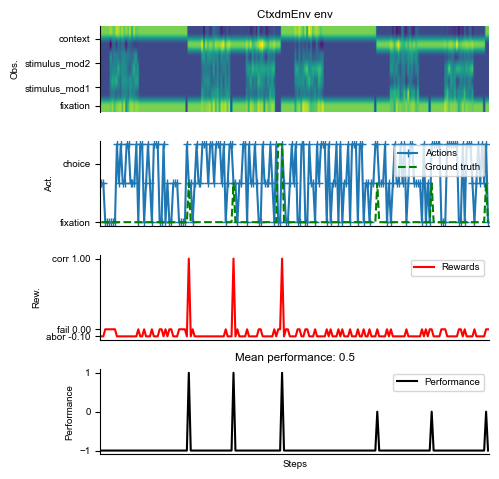

In [3]:
# make the env
env = Env("mante")

# visualize the task
plot_env(env)
plt.show()

In [4]:
# make the model
model = CTRNN(
    input_size=env.observation_space.shape[0],
    hidden_size=100,
    output_size=env.action_space.n,
    tau=100,
    dt=env.dt
)
model = IterateInput(model)  # run the RNN over the input sequence

# make the trainer
trainer = NGymLitTrainer(
    loss_fn="CrossEntropyLoss",
    accuracy=trial_choice_acc,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor="train_accuracy", mode="max", stopping_threshold=0.93, patience=np.inf)
    ]
)

# train the model on the environment (should take a few minutes)
trainer.fit(model, env)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | module  | IterateInput     | 11.2 K | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
11.2 K    Trainable params
0         Non-trainable params
11.2 K    Total params
0.045     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

## Evaluating the RNN

First, we need to record the activity of the RNN for the same set of conditions as the Mante2013 dataset.

In [5]:
# load the neural dataset
neural_dataset = Dataset("Mante2013", for_decoding=False)

Downloading: https://www.ini.uzh.ch/dam/jcr:ca4213cf-1692-4c3d-8aeb-d4c5081d2fd1/PFC%20data.zip


In [6]:
# record on the test environment (fixed trial period durations)
test_env = Env("mante-test")

conditions = neural_dataset["trial_info"]
for cond in conditions:
    # fix target positions
    cond["theta1"] = 0
    cond["theta2"] = math.pi

# time window when the activity is recorded in a trial
record_window = (350, 350+750)

model_dataset = record_ngym_lit(
    model=model,
    env=test_env,
    conditions=conditions,
    record_window=record_window
)

Visualize the low-dimensional dynamics of the data and the RNN using the Targeted Dimensionality Reduction method from the paper.

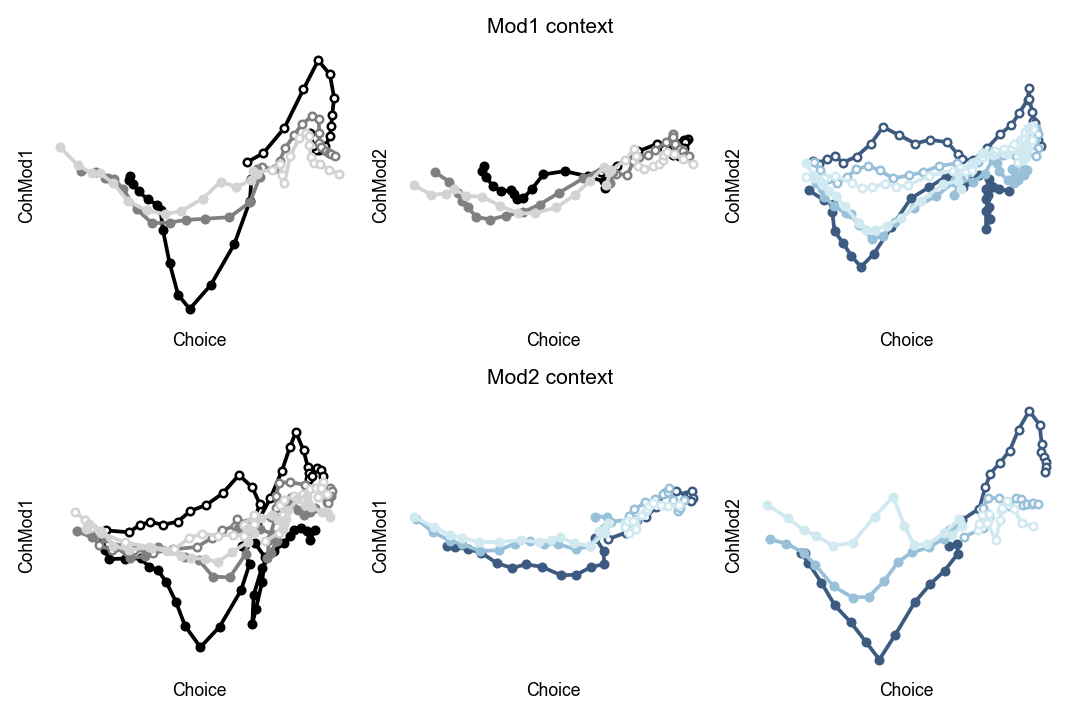

In [7]:
from diffscore.dataset.mante2013 import mante2013_tdr

dt = neural_dataset["dt"]
mante2013_tdr(neural_dataset["activity"], trial_conditions=neural_dataset["conditions"], dt=dt)
plt.show()

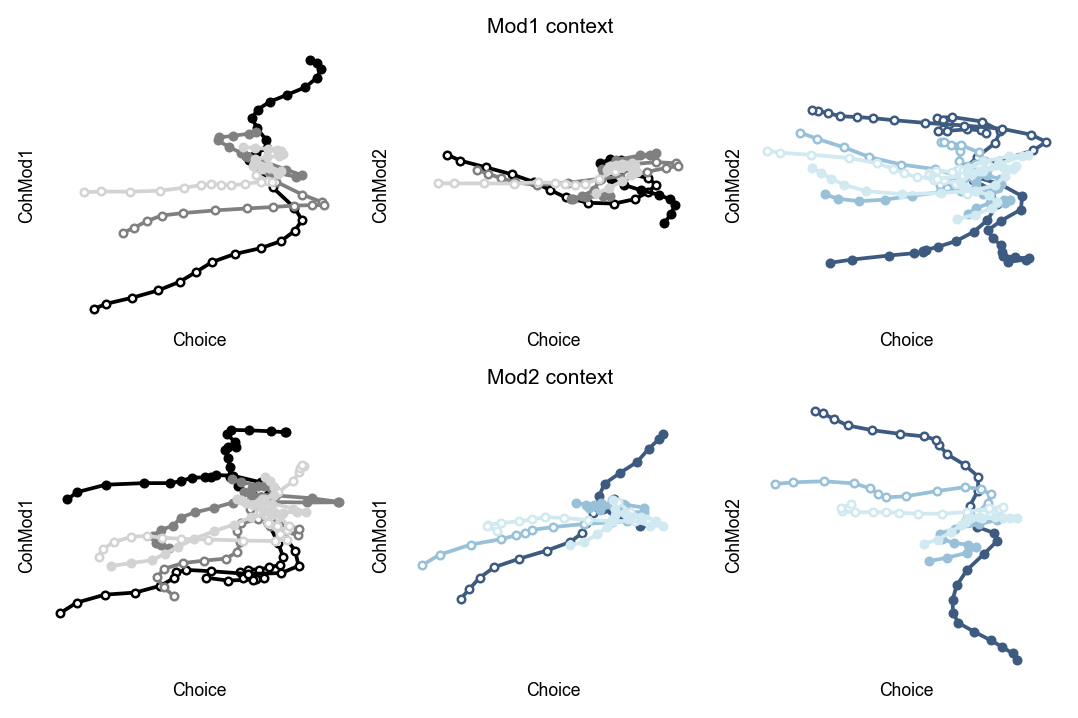

In [8]:
mante2013_tdr(model_dataset["activity"], trial_conditions=model_dataset["conditions"], dt=dt)
plt.show()

Quantify the similarity using similarity measures.

In [9]:

X = model_dataset["activity"]
Y = neural_dataset["activity"]

proc_measure = Measure("procrustes-angular-score")
cka_measure = Measure("cka")

proc_score = proc_measure(X, Y)
print("Procrustes angular score:", proc_score.item())

cka_score = cka_measure(X, Y)
print("CKA score:", cka_score.item())

Procrustes angular score: 0.3270524929034797
CKA score: 0.42720349063933166
